## Preprocess the data

In [7]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_excel("data_customer_classification 1.xlsx")
data

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78
...,...,...,...
124995,CS8433,2011-06-26,64
124996,CS7232,2014-08-19,38
124997,CS8731,2014-11-28,42
124998,CS8133,2013-12-14,13


### Cotegorize the clients in 3 aspects
0:low, 1:Medium and high: 2 based on total spendig money

In [16]:
# Extract relevant features
data['trans_date'] = pd.to_datetime(data['trans_date'])
data['year'] = data['trans_date'].dt.year

# Calculate total spending, maximum spending, and shopping frequency
customer_stats = data.groupby('customer_id').agg({
    'tran_amount': ['sum', 'max', 'count']
}).reset_index()

# Rename columns
customer_stats.columns = ['customer_id', 'total_spending', 'max_spending', 'shopping_frequency']

# Categorize customers into low, medium, and high value based on total spending
bins = [0, 100, 1000, np.inf]
labels = ['low', 'medium', 'high']
customer_stats['category'] = pd.cut(customer_stats['total_spending'], bins=bins, labels=labels)

# Convert categorical labels to numerical
customer_stats['category'] = customer_stats['category'].map({'low': 0, 'medium': 1, 'high': 2})

# Preview the processed data
customer_stats.head(10)

,customer_id,total_spending,max_spending,shopping_frequency,category
0,CS1112,1012,105,15,2
1,CS1113,1490,98,20,2
2,CS1114,1432,105,19,2
3,CS1115,1659,104,22,2
4,CS1116,857,105,13,1
5,CS1117,1185,100,17,2
6,CS1118,1011,101,15,2
7,CS1119,1158,102,15,2
8,CS1120,1677,105,24,2
9,CS1121,1524,104,26,2


## Create a clasification model using tensorflow.keras

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare the data for training
X = customer_stats[['total_spending', 'max_spending', 'shopping_frequency']].values
y = customer_stats['category'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Define the model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes for low, medium, high
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

/home/juand/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8033 - loss: 0.6620 - val_accuracy: 0.9619 - val_loss: 0.0961
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9664 - loss: 0.1088 - val_accuracy: 0.9692 - val_loss: 0.0734
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9687 - loss: 0.0767 - val_accuracy: 0.9746 - val_loss: 0.0606
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9793 - loss: 0.0643 - val_accuracy: 0.9801 - val_loss: 0.0527
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9815 - loss: 0.0513 - val_accuracy: 0.9819 - val_loss: 0.0483
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9834 - loss: 0.0450 - val_accuracy: 0.9837 - val_loss: 0.0380
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0407 - val_accuracy: 0.9855 - val_loss: 0.0303
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0352 - val_accuracy: 0.

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0023   
Test Accuracy: 1.00


###  Evaluate the Model

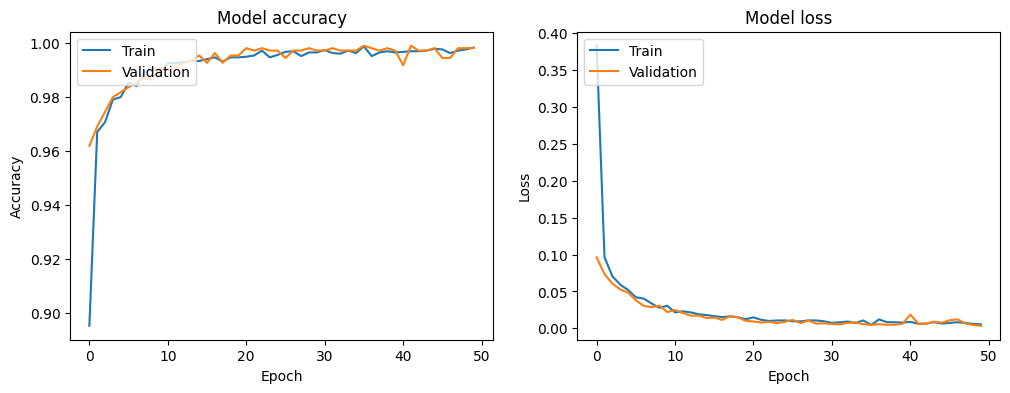

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Save the model

In [15]:
# Save the model
model.save('costumer_clasifciation.h5')

In [63]:
customer_data = np.array([[-1.68238784, 5.18531062, -177.95546849]])
category = np.argmax(model.predict(customer_data))

category

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1

In [44]:
X_test

array([[-0.57816154,  0.74636952, -0.60779349],
       [-1.68238784, -1.18531062, -1.95546849],
       [ 0.19158069,  0.74636952,  0.16230651],
       ...,
       [ 0.39527292,  0.74636952,  0.35483151],
       [-1.23640906, -1.57164665, -0.99284349],
       [ 0.93559336,  0.82363673,  1.1249315 ]])

In [71]:
for index, value in enumerate(y_train):
    if value == 0:
        print(index)